In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [17]:
df_train = pd.read_csv("./houseprices/train.csv")
df_test = pd.read_csv("./houseprices/test.csv")

In [19]:
#합침
all_data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
3         Lvl    AllPub    Corner  ...           0        0    NaN   NaN   
4         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         Normal  
1         NaN       0       5    2007        WD         Normal  
2         NaN       0       9    2008        WD         Normal  
3         NaN       0       2    2006        WD        Abnorml  
4         NaN       0      12    2008        WD         Normal  

[5 rows x 79 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023C25250C88>,
      dtype=object)

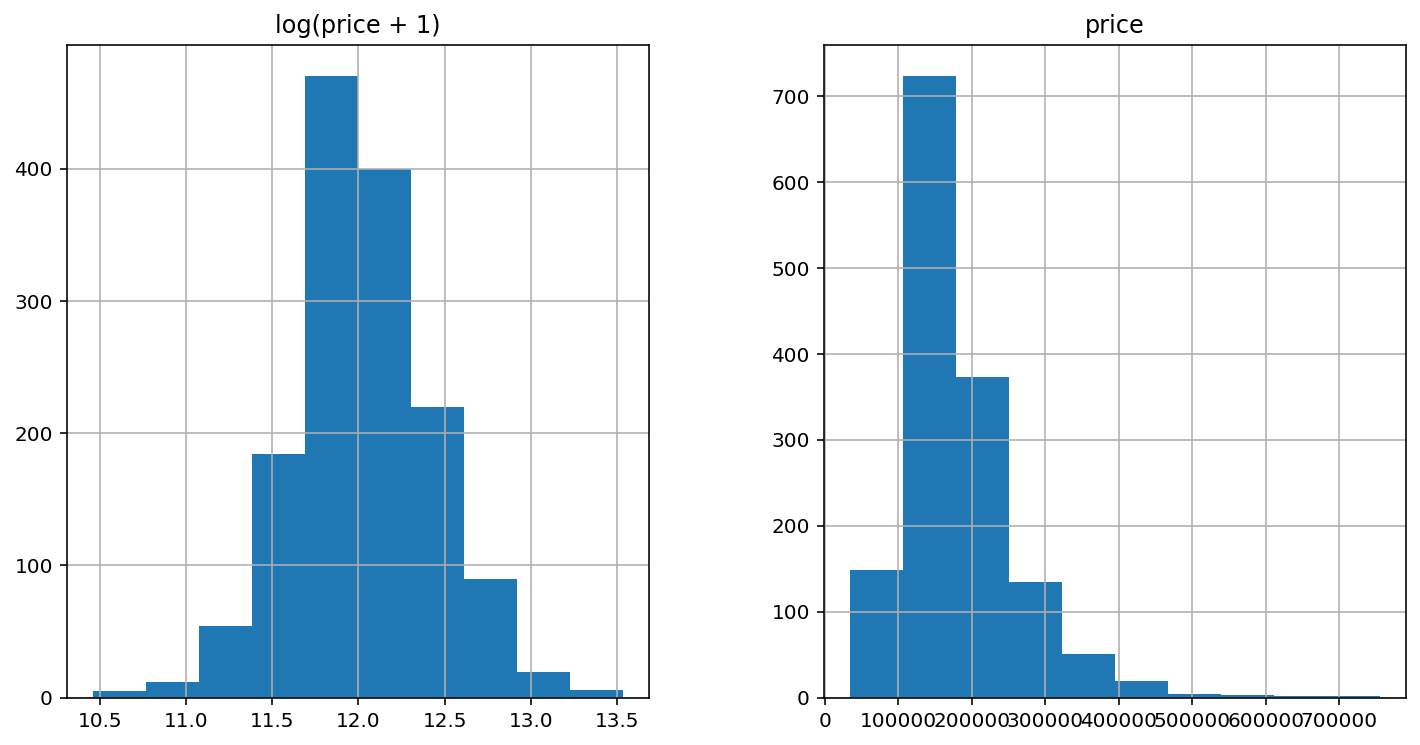

In [20]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df_train["SalePrice"], "log(price + 1)":np.log1p(df_train["SalePrice"])})
prices.hist()

In [28]:
#log transform the target:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index #숫자형
print(numeric_feats)
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats
skewed_feats = skewed_feats.index
skewed_feats
# all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [9]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 288)

In [10]:
#null?
for col in df_train.columns :
    if df_train[col].isnull().sum() != 0 :
        print(f'{col} : {df_train[col].isnull().sum() / df_train[col].shape[0]}')

LotFrontage : 0.1773972602739726
Alley : 0.9376712328767123
MasVnrType : 0.005479452054794521
MasVnrArea : 0.005479452054794521
BsmtQual : 0.025342465753424658
BsmtCond : 0.025342465753424658
BsmtExposure : 0.026027397260273973
BsmtFinType1 : 0.025342465753424658
BsmtFinType2 : 0.026027397260273973
Electrical : 0.0006849315068493151
FireplaceQu : 0.4726027397260274
GarageType : 0.05547945205479452
GarageYrBlt : 0.05547945205479452
GarageFinish : 0.05547945205479452
GarageQual : 0.05547945205479452
GarageCond : 0.05547945205479452
PoolQC : 0.9952054794520548
Fence : 0.8075342465753425
MiscFeature : 0.963013698630137


In [13]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [16]:
#null?
for col in all_data.columns :
    if all_data[col].isnull().sum() != 0 :
        print(f'{col} : {df_train[col].isnull().sum() / df_train[col].shape[0]}')

In [10]:
#creating matrices for sklearn:
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]
y = df_train.SalePrice

In [11]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
'''
'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par
'''
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [12]:
model_ridge = Ridge()

In [13]:
#The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

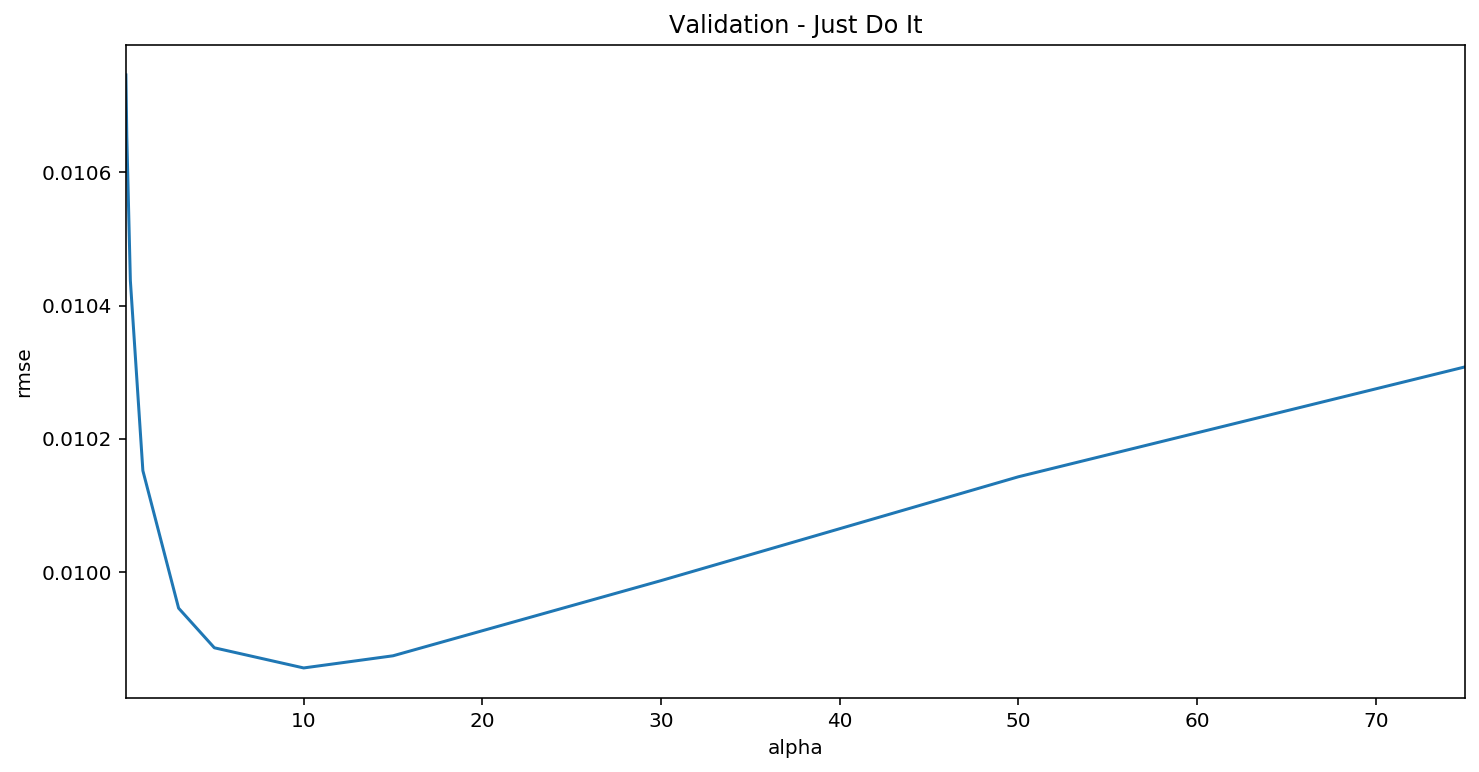

In [15]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
#Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.


In [16]:
cv_ridge.min()

0.009856187303325294

In [17]:
#Lasso로 alpha값 찾아보기
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

C:\Users\KIMDONGMIN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [18]:
rmse_cv(model_lasso).mean()

C:\Users\KIMDONGMIN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\KIMDONGMIN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\KIMDONGMIN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\KIMDONGMIN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.

0.01122759490996286

In [19]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [20]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 23 variables and eliminated the other 265 variables


In [24]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef

MiscVal            -0.000162
YrSold             -0.000151
GarageYrBlt        -0.000034
KitchenQual_TA     -0.000012
BsmtQual_Gd        -0.000000
BsmtQual_TA        -0.000000
BsmtCond_Fa        -0.000000
BsmtCond_Gd         0.000000
BsmtCond_Po        -0.000000
BsmtFinType1_BLQ   -0.000000
HeatingQC_Ex        0.000796
TotalBsmtSF         0.000991
BsmtFinSF1          0.001048
TotRmsAbvGrd        0.002059
1stFlrSF            0.002622
OverallCond         0.002744
Fireplaces          0.003211
LotArea             0.006129
OverallQual         0.007332
GrLivArea           0.012840
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

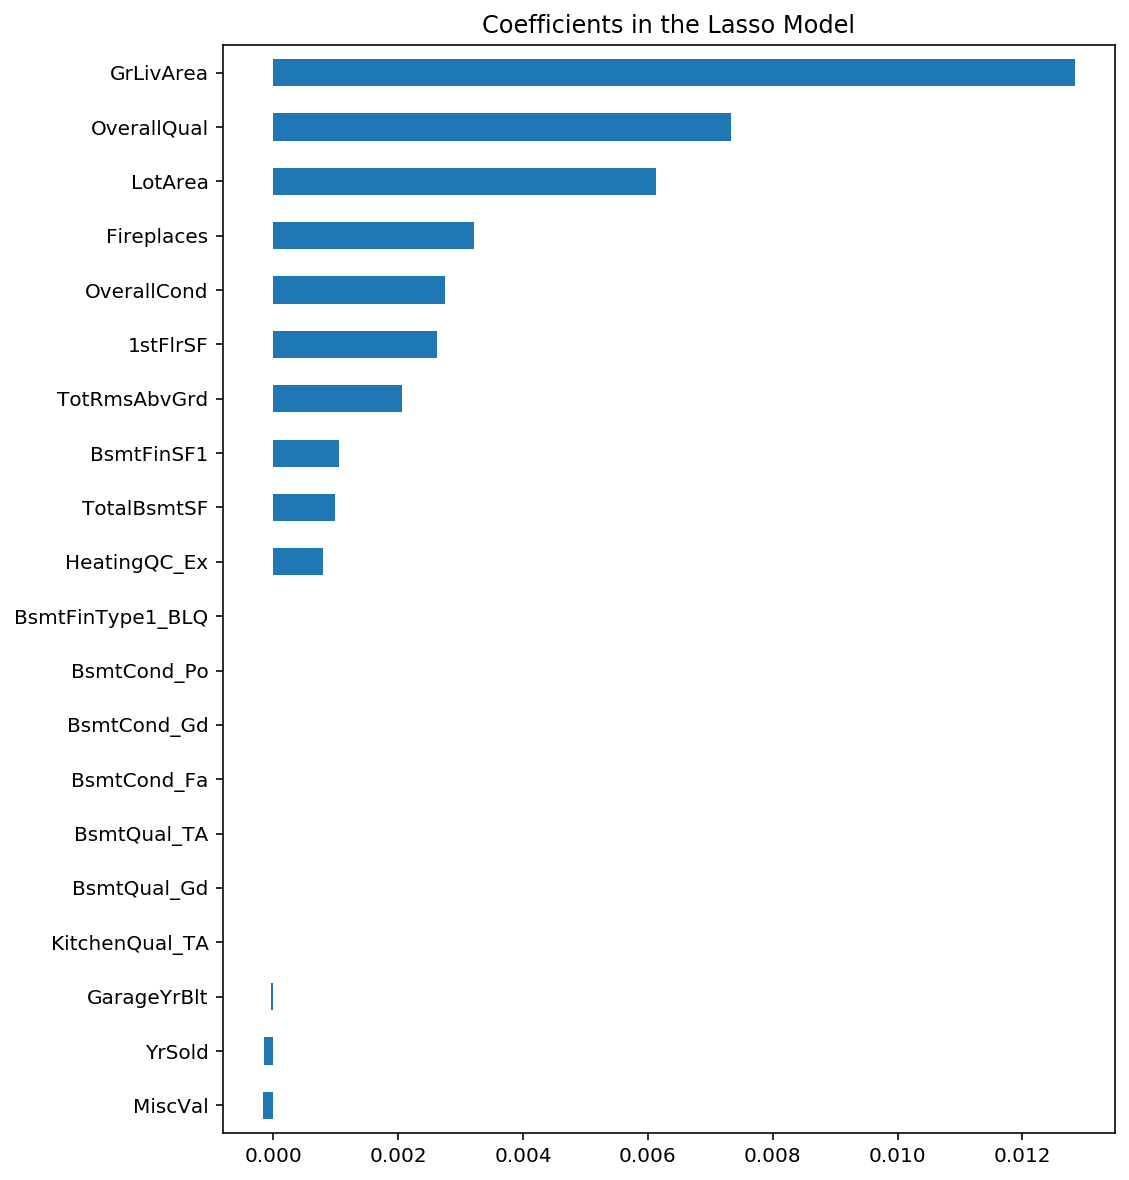

In [22]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

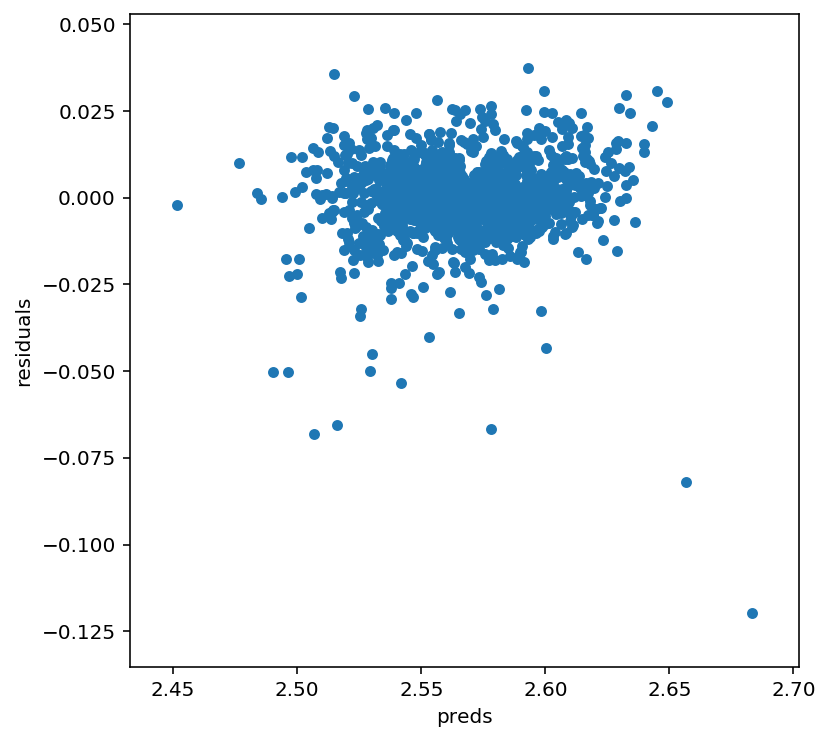

In [23]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [30]:
df_result=pd.read_csv('./houseprices/sample_submission.csv')
df_result['SalePrice'] = model_lasso.predict(X_test)
df_result.to_csv('./houseprices/sample_submission.csv', index=False)

In [31]:
df_result['SalePrice']

0       2.553808
1       2.558786
2       2.571038
3       2.581672
4       2.579796
          ...   
1454    2.516052
1455    2.525177
1456    2.573628
1457    2.546643
1458    2.596059
Name: SalePrice, Length: 1459, dtype: float64